In [1]:
import h5py, time
import click
import importlib
import numpy as np
import pandas as pd
import os
from pathlib import Path

from filelock import FileLock
import json
from ray.air import CheckpointConfig
from ray import tune
from ray.tune.integration.keras import TuneReportCallback
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.air.callbacks.wandb import WandbLoggerCallback
import tensorflow as tf
from tensorflow import keras
from scipy.stats import spearmanr
import wandb
import yaml

import model_zoo, utils

# set seed for reproducibility
np.random.seed(0)

2023-05-04 10:27:16.729690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 10:27:18.761006: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-04 10:27:18.761113: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-04 10:27:18.761121: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
from ray.air import session

In [5]:
# metrics

def Spearman(y_true, y_pred):
     return ( tf.py_function(spearmanr, [tf.cast(y_pred, tf.float32),
                       tf.cast(y_true, tf.float32)], Tout = tf.float32) ) 
from keras import backend as K

def pearson_r(y_true, y_pred):
    # use smoothing for not resulting in NaN values
    # pearson correlation coefficient
    # https://github.com/WenYanger/Keras_Metrics
    epsilon = 10e-5
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / (r_den + epsilon)
    return K.mean(r)

def load_deepstarr_data(
        data_split: str,
        data_dir='/home/chandana/projects/hominid_pipeline/data/deepstarr_data.h5',
        subsample: bool = False
    ) -> (np.ndarray, np.ndarray):
    """Load dataset"""

    # load sequences and labels
    with FileLock(os.path.expanduser(f"{data_dir}.lock")):
        with h5py.File(data_dir, "r") as dataset:
            x = np.array(dataset[f'x_{data_split}']).astype(np.float32)
            y = np.array(dataset[f'y_{data_split}']).astype(np.float32).transpose()
    if subsample:
        if data_split == "train":
            x = x[:80000]
            y = y[:80000]
        elif data_split == "valid":
            x = x[:20000]
            y = y[:20000]
        else:
            x = x[:10000]
            y = y[:10000]
    return x, y

def hominid_pipeline(config):

    # ==============================================================================
    # Load dataset
    # ==============================================================================

    x_train, y_train = load_deepstarr_data("train", subsample=False)
    x_valid, y_valid = load_deepstarr_data("valid", subsample=False)
    x_test, y_test = load_deepstarr_data("test", subsample=False)        

    N, L, A = x_train.shape
    output_shape = y_train.shape[-1]

    print(f"Input shape: {N, L, A}. Output shape: {output_shape}")

    config["input_shape"] = (L, A)
    config["output_shape"] = output_shape

    print(output_shape)

    # ==============================================================================
    # Build model
    # ==============================================================================

    print("Building model...")

    model = model_zoo.base_model(**config)

    return x_train, y_train, x_valid, y_valid, x_test, y_test, model

def tune_hominid(config: dict):

    x_train, y_train, x_valid, y_valid, x_test, y_test, model = hominid_pipeline(config)

    model.compile(
        tf.keras.optimizers.Adam(lr=0.001),
        loss='mse',
        metrics=[Spearman, pearson_r]
        )
    model.summary()
    
    # Write to the Tune trial directory, not the shared working dir
    tune_trial_dir = Path(session.get_trial_dir())

    # train model
    model.fit(
          x_train, y_train,
          epochs=60,
          batch_size=128,
          shuffle=True,
          validation_data=(x_valid, y_valid),
          callbacks=[
              TuneReportCallback({
                  "pearson_r": "pearson_r",
                  "val_pearson_r": "val_pearson_r",              
              }),
        ]
      )
    model.save_weights(f'{tune_trial_dir}/weights')
    
    return
    


In [4]:
config = {
    "conv1_activation": tune.choice(["relu"]),                     # activation on 1st layer conv 
    "conv1_batchnorm": tune.choice([False]),                       # batchnorm on 1st layer conv
    "conv1_channel_weight": tune.choice(["softconv", "se", None]), # soft attention on channels (1st layer conv)
    "conv1_dropout": 0.2,
    "conv1_filters": tune.choice([64, 96, 128, 256, 512]), 
    "conv1_kernel_size": tune.choice([15, 19]),    
    "conv1_pool_type": tune.choice(["attention", "max_pool"]),
    "conv1_max_pool": tune.choice([4, 8, 10, 20]),                 # if conv1 pool = max pool
    "conv1_attention_pool_size": tune.choice(range(40)),           # if conv1 pool = attention pool
    "conv1_type": tune.choice(["pw", "standard"]),                 # additive vs pairwise 1st conv layer
    "dense_activation": "relu",
    "dense_batchnorm": True,
    "dense_dropout": tune.choice([[0.3, 0.3], [0.4, 0.4], [0.5, 0.5]]), 
    "dense_units": tune.choice([[128, 128], [256, 128],[512, 256], [256, 256], [512, 512],[1024, 512]]),
    "mha_d_model": tune.choice([96, 192]),
    "mha_dropout": 0.1,
    "mha_head_type": tune.choice(["pool", "task_specific"]),       # shared vs task specific atttention
    "mha_heads": tune.choice([4, 8]),
    "mha_layernorm": False,
    "output_activation": "linear",
    "output_shape": None
}

In [ ]:
# initialization experiments with small initialization parameter (small standard deviations)
# use a small initializer for all convolutions in dense layers (0.005, 0.01)

In [7]:
smoke_test = False  # For testing purposes: set this to False to run the full experiment
analysis = tune.run(
    tune_hominid,
    name="tune_hominid_pipeline-full",
    callbacks=[WandbLoggerCallback(
        project="raytune-hominid_pipeline-full",
        log_config=True,
        upload_checkpoints=True,
        save_checkpoints=True
    )],
    scheduler=AsyncHyperBandScheduler(
        time_attr="training_iteration",
        max_t=400,
        grace_period=20
    ),
    metric="val_pearson_r",
    mode="max",
    stop={
        "val_pearson_r": 0.9,
        "training_iteration": 5 if smoke_test else 100
    },
    num_samples=1 if smoke_test else 100,
    resources_per_trial={
        "cpu": 4,
        "gpu": 1
    },
    config=config,

)

RESULTS_DIR = '/home/chandana/projects/hominid_pipeline/temp/'
print("Best hyperparameters found were: ", analysis.best_config)

pd.DataFrame.from_dict(
        analysis.best_config,
        orient='index'
).to_csv(
        RESULTS_DIR + 'tune_best.csv',
        header=True,
        index=True
        )
analysis.results_df.to_csv(RESULTS_DIR + 'tune_all.csv')

2023-05-04 10:30:12,173	INFO wandb.py:314 -- Already logged into W&B.
(pid=1281183) 2023-05-04 10:30:13.478811: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(pid=1281183) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=1281183) 2023-05-04 10:30:14.310527: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
(pid=1281183) 2023-05-04 10:30:14.310617: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
(pid=1281183) 2023-05-04 10:30:14.310625

(tune_hominid pid=1281183) Input shape: (402296, 249, 4). Output shape: 2
(tune_hominid pid=1281183) 2
(tune_hominid pid=1281183) Building model...


(tune_hominid pid=1281183) 2023-05-04 10:30:39.457006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(tune_hominid pid=1281183) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(tune_hominid pid=1281183) 2023-05-04 10:30:40.401608: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14239 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6
(tune_hominid pid=1281183) WARNING:tensorflow:From /home/chandana/miniforge3/envs/deepstarr/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/static_analysis/liveness.py:83: Analyzer.lamba_check (from tensorflow.python.autograph.pyct.static_analysis.liveness) is deprecated and will be removed after 2023-09-23

(tune_hominid pid=1281183) Model: "model"
(tune_hominid pid=1281183) __________________________________________________________________________________________________
(tune_hominid pid=1281183)  Layer (type)                   Output Shape         Param #     Connected to                     
(tune_hominid pid=1281183) ==================================================================================================
(tune_hominid pid=1281183)  input (InputLayer)             [(None, 249, 4)]     0           []                               
(tune_hominid pid=1281183)                                                                                                   
(tune_hominid pid=1281183)  conv1 (Conv1D)                 (None, 249, 96)      7392        ['input[0][0]']                  
(tune_hominid pid=1281183)                                                                                                   
(tune_hominid pid=1281183)  conv1_activation (Activation)  (None, 249, 96)  

(tune_hominid pid=1281183) 2023-05-04 10:30:42.133454: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1602747264 exceeds 10% of free system memory.


(tune_hominid pid=1281183) Epoch 1/60


(tune_hominid pid=1281183) WARNING:tensorflow:AutoGraph could not transform <function Spearman at 0x7f87a4d37170> and will run it as-is.
(tune_hominid pid=1281183) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(tune_hominid pid=1281183) Cause: Unknown node type <gast.gast.Import object at 0x7f86b437c5d0>
(tune_hominid pid=1281183) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(tune_hominid pid=1281183) WARNING:tensorflow:AutoGraph could not transform <function Spearman at 0x7f87a4d37170> and will run it as-is.
(tune_hominid pid=1281183) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(tune_hominid pid=1281183) Cause: Unknown node type <gast.gast.Import object at 0x7f86b437c5d0>
(tune_hominid pid=1281183) To silence t

 756/3143 [======>.......................] - ETA: 24s - loss: 2.3713 - Spearman: 0.4821 - pearson_r: 0.3288


1438/3143 [============>.................] - ETA: 17s - loss: 2.1377 - Spearman: 0.5255 - pearson_r: 0.4154


2130/3143 [===================>..........] - ETA: 10s - loss: 2.0211 - Spearman: 0.5472 - pearson_r: 0.4604


2848/3143 [==========================>...] - ETA: 3s - loss: 1.9399 - Spearman: 0.5604 - pearson_r: 0.4896


3141/3143 [============================>.] - ETA: 0s - loss: 1.9146 - Spearman: 0.5644 - pearson_r: 0.4987


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,pearson_r,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,val_pearson_r,warmup_time
tune_hominid_2db57_00000,2023-05-04_10-32-35,False,,41eeb579ac8c43a8929452355b0b6745,citra,3,143.48.44.146,0.631274,1281183,138.444,33.8047,138.444,1683210755,0,,3,2db57_00000,0.563095,0.0046525


2023-05-04 10:31:27,795	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.723 s, which may be a performance bottleneck.
2023-05-04 10:31:27,796	WARNING util.py:244 -- The `process_trial_result` operation took 0.724 s, which may be a performance bottleneck.
2023-05-04 10:31:27,796	WARNING util.py:244 -- Processing trial results took 0.724 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-04 10:31:27,796	WARNING util.py:244 -- The `process_trial_result` operation took 0.725 s, which may be a performance bottleneck.


3143/3143 [==============================] - 45s 12ms/step - loss: 1.9145 - Spearman: 0.5644 - pearson_r: 0.4987 - val_loss: 1.7375 - val_Spearman: 0.5680 - val_pearson_r: 0.5070
(tune_hominid pid=1281183) Epoch 2/60
 685/3143 [=====>........................] - ETA: 25s - loss: 1.6316 - Spearman: 0.6068 - pearson_r: 0.5993


1462/3143 [============>.................] - ETA: 17s - loss: 1.6246 - Spearman: 0.6107 - pearson_r: 0.6035


2196/3143 [===================>..........] - ETA: 9s - loss: 1.6134 - Spearman: 0.6117 - pearson_r: 0.6070


2962/3143 [===========================>..] - ETA: 1s - loss: 1.6025 - Spearman: 0.6138 - pearson_r: 0.6104


3143/3143 [==============================] - 34s 11ms/step - loss: 1.6002 - Spearman: 0.6140 - pearson_r: 0.6112 - val_loss: 1.4876 - val_Spearman: 0.5890 - val_pearson_r: 0.5470
(tune_hominid pid=1281183) Epoch 3/60
 563/3143 [====>.........................] - ETA: 26s - loss: 1.5396 - Spearman: 0.6140 - pearson_r: 0.6253


1329/3143 [===========>..................] - ETA: 18s - loss: 1.5448 - Spearman: 0.6185 - pearson_r: 0.6276


2069/3143 [==================>...........] - ETA: 10s - loss: 1.5399 - Spearman: 0.6211 - pearson_r: 0.6297


2858/3143 [==========================>...] - ETA: 2s - loss: 1.5354 - Spearman: 0.6221 - pearson_r: 0.6312


3142/3143 [============================>.] - ETA: 0s - loss: 1.5354 - Spearman: 0.6225 - pearson_r: 0.6313


2023-05-04 10:32:35,171	WARNING tune.py:147 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2023-05-04 10:32:35,892	ERROR tune.py:794 -- Trials did not complete: [tune_hominid_2db57_00000, tune_hominid_2db57_00001, tune_hominid_2db57_00002, tune_hominid_2db57_00003, tune_hominid_2db57_00004, tune_hominid_2db57_00005, tune_hominid_2db57_00006, tune_hominid_2db57_00007, tune_hominid_2db57_00008, tune_hominid_2db57_00009, tune_hominid_2db57_00010, tune_hominid_2db57_00011, tune_hominid_2db57_00012, tune_hominid_2db57_00013, tune_hominid_2db57_00014, tune_hominid_2db57_00015, tune_hominid_2db57_00016, tune_hominid_2db57_00017, tune_hominid_2db57_00018, tune_hominid_2db57_00019, tune_hominid_2db57_00020, tune_hominid_2db57_00021, tune_hominid_2db57_00022, tune_hominid_2db57_00023, tune_hominid_2db57_00024, tune_hominid_2db57_00025, tune_hominid_2db57

3143/3143 [==============================] - 34s 11ms/step - loss: 1.5354 - Spearman: 0.6225 - pearson_r: 0.6313 - val_loss: 1.4366 - val_Spearman: 0.5994 - val_pearson_r: 0.5631
(tune_hominid pid=1281183) Epoch 4/60
  11/3143 [..............................] - ETA: 35s - loss: 1.5612 - Spearman: 0.6241 - pearson_r: 0.6511
Best hyperparameters found were:  {'conv1_activation': 'relu', 'conv1_batchnorm': False, 'conv1_channel_weight': None, 'conv1_dropout': 0.2, 'conv1_filters': 96, 'conv1_kernel_size': 19, 'conv1_pool_type': 'max_pool', 'conv1_max_pool': 10, 'conv1_attention_pool_size': 0, 'conv1_type': 'standard', 'dense_activation': 'relu', 'dense_batchnorm': True, 'dense_dropout': [0.3, 0.3], 'dense_units': [512, 512], 'mha_d_model': 192, 'mha_dropout': 0.1, 'mha_head_type': 'pool', 'mha_heads': 8, 'mha_layernorm': False, 'output_activation': 'linear', 'output_shape': None}


In [ ]:
model = model_zoo.base_model(**config)

    return x_train, y_train, x_valid, y_valid, x_test, y_test, model

def tune_hominid(config: dict):

    x_train, y_train, x_valid, y_valid, x_test, y_test, model = hominid_pipeline(config)

    model.compile(
        tf.keras.optimizers.Adam(lr=0.001),
        loss='mse',
        metrics=[Spearman, pearson_r]
        )
    model.summary()

In [40]:
file_path = "/home/chandana/projects/hominid_pipeline/temp"

In [11]:
importlib.reload(model_zoo)



config = {
    "conv1_activation": np.random.choice(["relu"]), # relu
    "conv1_batchnorm": np.random.choice([False]), 
    "conv1_channel_weight": np.random.choice(["softconv", "se"]),
    "conv1_dropout": 0.2,
    "conv1_filters": np.random.choice([256, 512]), # go to 256, 512
    "conv1_kernel_size": int(np.random.choice([15, 19])), # go to 11 15 19
    "conv1_max_pool": 10,
    "conv1_pool_type": "attention", 
    "conv1_attention_pool_size": np.random.choice(range(40)), # --> tune.choice(0-40)
    "conv1_type": np.random.choice(["pw", "standard"]),
    "dense_activation": "relu",
    "dense_batchnorm": True,
    "dense_dropout": [0.3, 0.3], # go to 0.30.3 to 0.5 0.5
    "dense_units": [128, 256],
    "input_shape": None,
    "mha_d_model": np.random.choice([96, 192]),
    "mha_dropout": 0.1,
    "mha_head_type": np.random.choice(["pool", "task_specific"]),
    "mha_heads": np.random.choice([4, 8]),
    "mha_layernorm": False,
    "output_activation": "linear",
    "output_shape": None
}

# wandb.init(project='raytune-hominid_pipeline', name='test_2', config=config)

x_train, y_train, x_valid, y_valid, x_test, y_test, model = hominid_pipeline(config)

model.compile(
    tf.keras.optimizers.Adam(lr=0.001),
    loss='mse',
    metrics=[Spearman, pearson_r]
    )
model.summary()

# train model
model.fit(
      x_train, y_train,
      epochs=1,
      batch_size=128,
      shuffle=True,
      validation_data=(x_valid, y_valid),
#     callbacks=[
#           wandb.keras.WandbCallback(
#               save_model=(True)
#           )]
)
# wandb.finish()

Input shape: (80000, 249, 4). Output shape: 2
2
Building model...


2023-05-03 17:01:09.708727: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 17:01:10.237977: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14239 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/chandana/projects/hominid_pipeline/model_zoo.py:11: RuntimeWarning: divide by zero encountered in long_scalars
  self.pool_size = pool_size
/home/chandana/projects/hominid_pipeline/model_zoo.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  


ValueError: Exception encountered when calling layer "attention_pooling" (type AttentionPooling).

in user code:

    File "/home/chandana/projects/hominid_pipeline/model_zoo.py", line 28, in call  *
        raw_weights = self.dense(inputs)
    File "/home/chandana/miniforge3/envs/deepstarr/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'conv1d' (type Conv1D).
    
    Negative dimension size caused by subtracting 1 from 0 for '{{node attention_pooling/conv1d/Conv1D/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](attention_pooling/conv1d/Conv1D/Reshape, attention_pooling/conv1d/Conv1D/ExpandDims_1)' with input shapes: [?,1,0,128], [1,1,128,128].
    
    Call arguments received by layer 'conv1d' (type Conv1D):
      • inputs=tf.Tensor(shape=(None, 0, 0, 128), dtype=float32)


Call arguments received by layer "attention_pooling" (type AttentionPooling):
  • inputs=tf.Tensor(shape=(None, 249, 128), dtype=float32)

In [12]:
print("Best hyperparameters found were: ", analysis.best_config)

Best hyperparameters found were:  {'conv1_activation': 'relu', 'conv1_batchnorm': False, 'conv1_channel_weight': 'softconv', 'conv1_dropout': 0.2, 'conv1_filters': 128, 'conv1_kernel_size': 19, 'conv1_pool_type': 'attention', 'conv1_max_pool': 20, 'conv1_attention_pool_size': 23, 'conv1_type': 'pw', 'dense_activation': 'relu', 'dense_batchnorm': True, 'dense_dropout': [0.3, 0.3], 'dense_units': [256, 128], 'mha_d_model': 192, 'mha_dropout': 0.1, 'mha_head_type': 'task_specific', 'mha_heads': 8, 'mha_layernorm': False, 'output_activation': 'linear', 'output_shape': None}


In [20]:
len(analysis.results_df)

50

Best hyperparameters found were:  {'conv1_activation': 'relu', 'conv1_batchnorm': False, 'conv1_channel_weight': 'softconv', 'conv1_dropout': 0.2, 'conv1_filters': 256, 'conv1_kernel_size': 15, 'conv1_pool_type': 'max_pool', 'conv1_max_pool': 8, 'conv1_attention_pool_size': 15, 'conv1_type': 'standard', 'dense_activation': 'relu', 'dense_batchnorm': True, 'dense_dropout': [0.3, 0.3], 'dense_units': [512, 256], 'mha_d_model': 192, 'mha_dropout': 0.1, 'mha_head_type': 'pool', 'mha_heads': 8, 'mha_layernorm': False, 'output_activation': 'linear', 'output_shape': None}


# Analyze results

In [3]:
import matplotlib.pyplot as plt

In [4]:
analysis = pd.read_csv('/home/chandana/projects/hominid/results/sweep_table.csv')
analysis

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,conv1_activation,conv1_batchnorm,...,trial_log_path,iterations_since_restore,pearson_r,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,training_iteration,warmup_time
0,tune_hominid_2e9a0_00005,finished,-,ckochath,NaN,2023-04-06T18:46:14.000Z,2557,NaN,relu,True,...,/home/chandana/ray_results/tune_hominid/tune_h...,60,0.888635,2550.752711,42.304018,2550.752711,1680809328,0,60,0.005102
1,tune_hominid_2e9a0_00046,finished,-,ckochath,NaN,2023-04-07T08:13:10.000Z,1443,NaN,relu,False,...,/home/chandana/ray_results/tune_hominid/tune_h...,60,0.888559,1436.601748,23.748997,1436.601748,1680856630,0,60,0.005109
2,tune_hominid_2e9a0_00022,finished,-,ckochath,NaN,2023-04-07T00:49:25.000Z,4241,NaN,relu,False,...,/home/chandana/ray_results/tune_hominid/tune_h...,60,0.886563,4234.652682,70.478082,4234.652682,1680832803,0,60,0.005227
3,tune_hominid_2e9a0_00007,finished,-,ckochath,NaN,2023-04-06T19:56:51.000Z,3070,NaN,relu,False,...,/home/chandana/ray_results/tune_hominid/tune_h...,60,0.885639,3064.092025,50.814463,3064.092025,1680814079,0,60,0.005103
4,tune_hominid_2e9a0_00036,finished,-,ckochath,NaN,2023-04-07T04:54:07.000Z,4173,NaN,relu,False,...,/home/chandana/ray_results/tune_hominid/tune_h...,60,0.885317,4166.478738,69.190704,4166.478738,1680847417,0,60,0.004926
5,tune_hominid_2e9a0_00049,finished,-,ckochath,NaN,2023-04-07T08:54:30.000Z,1611,NaN,relu,True,...,/home/chandana/ray_results/tune_hominid/tune_h...,60,0.885305,1604.369986,26.542195,1604.369986,1680859277,0,60,0.006063
6,tune_hominid_2e9a0_00020,finished,-,ckochath,NaN,2023-04-06T23:52:14.000Z,2829,NaN,relu,True,...,/home/chandana/ray_results/tune_hominid/tune_h...,60,0.881746,2823.065363,46.830002,2823.065363,1680827960,0,60,0.005236
7,tune_hominid_2e9a0_00006,finished,-,ckochath,NaN,2023-04-06T19:28:54.000Z,1674,NaN,relu,True,...,/home/chandana/ray_results/tune_hominid/tune_h...,60,0.878790,1667.439738,27.505669,1667.439738,1680811005,0,60,0.004855
8,tune_hominid_2e9a0_00026,finished,-,ckochath,NaN,2023-04-07T02:32:52.000Z,2182,NaN,relu,True,...,/home/chandana/ray_results/tune_hominid/tune_h...,60,0.876017,2174.928653,36.118381,2174.928653,1680836951,0,60,0.005168
9,tune_hominid_2e9a0_00016,finished,-,ckochath,NaN,2023-04-06T22:45:32.000Z,1813,NaN,relu,False,...,/home/chandana/ray_results/tune_hominid/tune_h...,60,0.873120,1806.488476,29.868063,1806.488476,1680822941,0,60,0.004921


In [10]:
for i in range(5):
    print(analysis.loc[i]['trial_log_path'])
    print("\n")
    print(analysis.loc[i]['pearson_r'])
    print("\n")

/home/chandana/ray_results/tune_hominid/tune_hominid_2e9a0_00005_5_conv1_activation=relu,conv1_batchnorm=True,conv1_channel_weight=se,conv1_filters=256,conv1_kernel_size=_2023-04-06_14-46-12


0.8886346220970154


/home/chandana/ray_results/tune_hominid/tune_hominid_2e9a0_00046_46_conv1_activation=relu,conv1_batchnorm=False,conv1_channel_weight=se,conv1_filters=128,conv1_kernel_siz_2023-04-07_04-13-09


0.8885594606399536


/home/chandana/ray_results/tune_hominid/tune_hominid_2e9a0_00022_22_conv1_activation=relu,conv1_batchnorm=False,conv1_channel_weight=se,conv1_filters=512,conv1_kernel_siz_2023-04-06_20-49-23


0.886563241481781


/home/chandana/ray_results/tune_hominid/tune_hominid_2e9a0_00007_7_conv1_activation=relu,conv1_batchnorm=False,conv1_channel_weight=se,conv1_filters=512,conv1_kernel_size_2023-04-06_15-56-50


0.8856391906738281


/home/chandana/ray_results/tune_hominid/tune_hominid_2e9a0_00036_36_conv1_activation=relu,conv1_batchnorm=False,conv1_channel_weight=se,conv1_fil

In [9]:
params_path = "/home/chandana/ray_results/tune_hominid/tune_hominid_2e9a0_00005_5_conv1_activation=relu,conv1_batchnorm=True,conv1_channel_weight=se,conv1_filters=256,conv1_kernel_size=_2023-04-06_14-46-12"
json.load(open(f"{params_path}/params.json"))

{'conv1_activation': 'relu',
 'conv1_batchnorm': True,
 'conv1_channel_weight': 'se',
 'conv1_dropout': 0.2,
 'conv1_filters': 256,
 'conv1_kernel_size': 19,
 'conv1_max_pool': 10,
 'conv1_pool_type': 'attention',
 'conv1_type': 'pw',
 'dense_activation': 'relu',
 'dense_batchnorm': True,
 'dense_dropout': [0.3, 0.3],
 'dense_units': [512, 512],
 'input_shape': None,
 'mha_d_model': 96,
 'mha_dropout': 0.1,
 'mha_head_type': 'pool',
 'mha_heads': 8,
 'mha_layernorm': False,
 'mha_pool_type': 'attention',
 'output_activation': 'linear',
 'output_shape': None}

In [ ]:
    data =  {
        "num_epochs": 100,
        "batch_size": 128,
        "lr": 1e-3,
        'augmentations': params['augmentations'],
        "wandb_log": True,
        "wandb_project": "hominid_hepg2-v2",
        "wandb_run_name": path,
        "save_path": save_path,
        "framework": 'tensorflow',
        "dataset": "hepg2",
        
        "model_fn": {
            'conv1_activation': params["conv1_activation"],
            'conv1_batchnorm': False,
            'conv1_dropout': 0.2,
            'conv1_filters': 128,
            'conv1_kernel_size': 15,
            'conv1_pool_type': 'attention',
            'conv1_max_pool': 10,
            'conv1_type': params['conv1_type'],
            'conv1_channel_weight': params['conv1_channel_weight'],
            'dense_activation': 'relu',
            'dense_batchnorm': True,
            'dense_dropout': [0.4, 0.4],
            'dense_units': [256, 256],
            'input_shape': None,
            'mha_d_model': 96,
            'mha_dropout': 0.1,
            'mha_heads': 4,
            'mha_layernorm': False,
            'mha_pool_type': params['mha_pool_type'],
            'mha_head_type': params['mha_head_type'],
            'output_activation': "linear",
            'output_shape': None,
        }
    }

In [16]:
analysis = analysis.drop(columns=['Name', 'State', 'Notes', 'User', 'Tags', 'Created', 'Runtime', 'Sweep', 'hostname', 
                      'node_ip', 'pid', 'trial_id', 'iterations_since_restore', 'time_since_restore', 'time_this_iter_s', 'time_total_s', 'timestamp',
       'timesteps_since_restore', 'training_iteration', 'warmup_time', 'date'])

analysis.loc[0]['trial_log_path']

'/home/chandana/ray_results/tune_hominid/tune_hominid_2e9a0_00005_5_conv1_activation=relu,conv1_batchnorm=True,conv1_channel_weight=se,conv1_filters=256,conv1_kernel_size=_2023-04-06_14-46-12'

In [20]:
config

{'conv1_activation': <ray.tune.search.sample.Categorical at 0x7f1bb9478750>,
 'conv1_batchnorm': <ray.tune.search.sample.Categorical at 0x7f1bb9478790>,
 'conv1_channel_weight': <ray.tune.search.sample.Categorical at 0x7f1bb9478810>,
 'conv1_dropout': 0.2,
 'conv1_filters': <ray.tune.search.sample.Categorical at 0x7f1bb94788d0>,
 'conv1_kernel_size': <ray.tune.search.sample.Categorical at 0x7f1bb9478950>,
 'conv1_max_pool': 10,
 'conv1_pool_type': 'attention',
 'conv1_type': 'pw',
 'dense_activation': 'relu',
 'dense_batchnorm': True,
 'dense_dropout': <ray.tune.search.sample.Categorical at 0x7f1bb94789d0>,
 'dense_units': <ray.tune.search.sample.Categorical at 0x7f1bb9478a90>,
 'input_shape': None,
 'mha_d_model': <ray.tune.search.sample.Categorical at 0x7f1bb9478b10>,
 'mha_dropout': 0.1,
 'mha_head_type': 'pool',
 'mha_heads': <ray.tune.search.sample.Categorical at 0x7f1bb9478b90>,
 'mha_layernorm': False,
 'mha_pool_type': 'attention',
 'output_activation': 'linear',
 'output_shape

In [17]:
analysis.columns

Index(['conv1_activation', 'conv1_batchnorm', 'conv1_channel_weight',
       'conv1_dropout', 'conv1_filters', 'conv1_kernel_size', 'conv1_max_pool',
       'conv1_pool_type', 'conv1_type', 'dense_activation', 'dense_batchnorm',
       'dense_dropout', 'dense_units', 'experiment_id', 'input_shape',
       'mha_d_model', 'mha_dropout', 'mha_head_type', 'mha_heads',
       'mha_layernorm', 'mha_pool_type', 'output_activation', 'output_shape',
       'trial_log_path', 'pearson_r'],
      dtype='object')

In [18]:
analysis['conv1_activation']

0            relu
1            relu
2            relu
3            relu
4            relu
5            relu
6            relu
7            relu
8            relu
9            relu
10           relu
11           relu
12    exponential
13           relu
14           relu
15           relu
16           relu
17           relu
18           relu
19           relu
20           relu
21           relu
22           relu
23           relu
24           relu
25    exponential
26           relu
27    exponential
28           relu
29    exponential
30    exponential
31    exponential
32    exponential
33    exponential
34    exponential
35    exponential
36    exponential
37    exponential
38    exponential
39    exponential
40    exponential
41    exponential
42    exponential
43    exponential
44    exponential
45    exponential
46    exponential
47    exponential
48    exponential
49    exponential
Name: conv1_activation, dtype: object

<AxesSubplot:xlabel='conv1_activation', ylabel='pearson_r'>

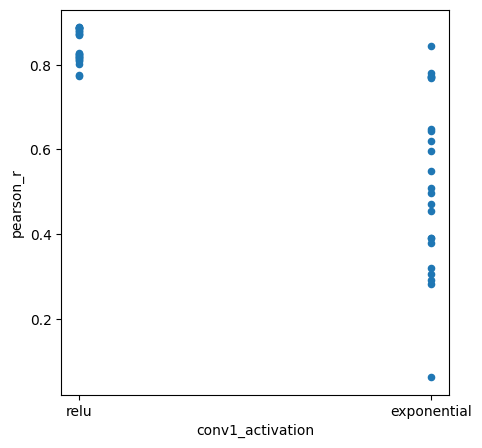

In [28]:
# analysis[analysis["conv1_channel_weight"] == weight]

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(1,1,1)

analysis.plot.scatter(
    x='conv1_activation',
    y='pearson_r',
    ax=ax
)

IndexError: index 0 is out of bounds for axis 0 with size 0

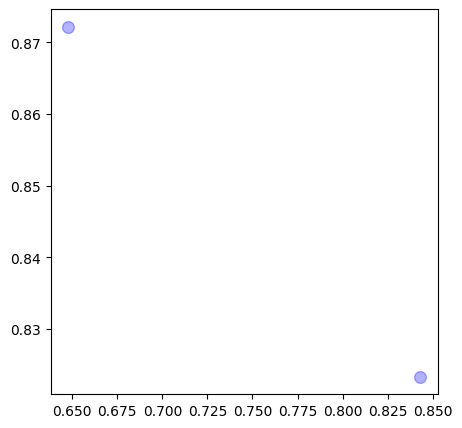

In [26]:
# Plot scatterplots


ACTIVATIONS = ['relu','exponential']
BN = [True, False]
conv1_filters = [128, 192, 256, 512]
conv1_channel_weight = ["softconv", "se"]

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(1,1,1)

for k, weight in enumerate(conv1_channel_weight):

    res = analysis[analysis["conv1_channel_weight"] == weight]

    for i, filters in enumerate(conv1_filters):

        r1 = res[res["conv1_filters"] == filters]

        for j, bn in enumerate(BN):

            d1 = r1[r1["conv1_batchnorm"] == bn]

            x = d1[d1["conv1_activation"] == "exponential"].pearson_r.to_numpy()[0]
            y = d1[d1["conv1_activation"] == "relu"].pearson_r.to_numpy()[0]
                       
            if ((k == 0) and (j == 0)):
                label = filters
            else:
                label = None

            plt.plot(x, y, '.', color="blue", label=None, markersize=17, alpha=0.3)
#             plt.plot(x1_rel, y1_rel, '>', color="blue", label=None, markersize=12, alpha=0.3)
            
# x = entropy_df[entropy_df["index"] == 266].entropy.to_numpy()
# y = entropy_df[entropy_df["index"] == 266].snr.to_numpy()
# plt.plot(x, y, '.', color="red", label=None, markersize=20, alpha=1) #alpha=0.5

# x = entropy_df[entropy_df["index"] == 166].entropy.to_numpy()
# y = entropy_df[entropy_df["index"] == 166].snr.to_numpy()
# plt.plot(x, y, '>', color="orange", label=None, markersize=20, alpha=1) #alpha=0.5

ax.set_xlabel("KLD (k-attr-mean)", fontsize=15)
ax.set_ylabel("Attribution SNR", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0, 7)
plt.tight_layout();

plt.show()

In [25]:
x

array([0.64777267, 0.31937146])

In [7]:
analysis.sort_values('pearson_r', ascending=False).loc[0]

Name                                                 tune_hominid_2e9a0_00005
State                                                                finished
Notes                                                                       -
User                                                                 ckochath
Tags                                                                      NaN
Created                                              2023-04-06T18:46:14.000Z
Runtime                                                                  2557
Sweep                                                                     NaN
conv1_activation                                                         relu
conv1_batchnorm                                                          True
conv1_channel_weight                                                       se
conv1_dropout                                                             0.2
conv1_filters                                                   